In [1]:
import numpy as np
import torch

torch.manual_seed(0)

import gpytorch
import botorch

from itertools import combinations

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)

## 10.2 Formulating a preference optimization problem and formatting pairwise comparison data

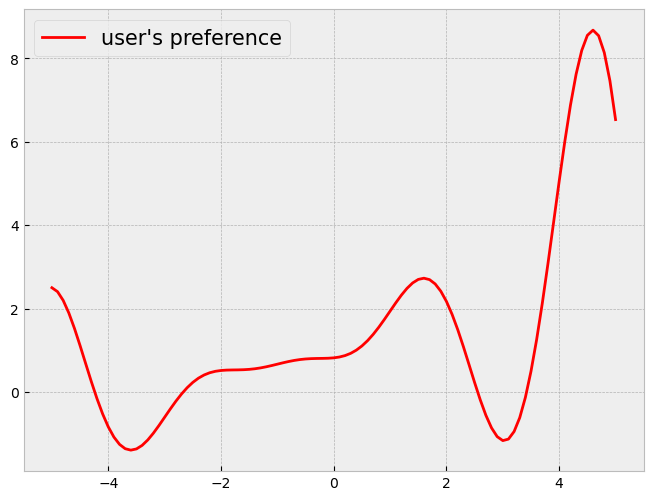

In [2]:
def objective(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1 + x / 3
    return y


lb = -5
ub = 5

bounds = torch.tensor([[lb], [ub]], dtype=torch.float)

xs = torch.linspace(lb, ub, 101)
ys = objective(xs)

plt.plot(xs, ys, label="user's preference", c="r")
plt.legend(fontsize=15)
# plt.axis("off")

plt.show()

In [3]:
def compare(y):
    assert y.numel() == 2
    
    if y.flatten()[0] > y.flatten()[1]:
        return torch.tensor([[0, 1]]).long()
    else:
        return torch.tensor([[1, 0]]).long()


def observe_and_append_data(x_next, f, x_train, comp_train, tol=1e-3):
    """
    x_next should be an experiment, i.e., a pair of locations
    """
    x_next = x_next.to(x_train)
    y_next = f(x_next)
    comp_next = compare(y_next)

    n = x_train.shape[-2]
    new_x_train = x_train.clone()
    new_comp_next = comp_next.clone() + n
    n_dups = 0

    ### first element
    dup_ind = torch.where(
        torch.all(torch.isclose(x_train, x_next[0], atol=tol), axis=1)
    )[0]
    if dup_ind.nelement() == 0:
        new_x_train = torch.cat([x_train, x_next[0].unsqueeze(-2)])
    else:
        # replace n with the duplicated index
        # decrement the other index
        new_comp_next = torch.where(new_comp_next == n, dup_ind, new_comp_next - 1)

        n_dups += 1

    ### second element
    dup_ind = torch.where(
        torch.all(torch.isclose(new_x_train, x_next[1], atol=tol), axis=1)
    )[0]
    if dup_ind.nelement() == 0:
        new_x_train = torch.cat([new_x_train, x_next[1].unsqueeze(-2)])
    else:
        # replace n + 1 with the duplicated index
        new_comp_next = torch.where(
            new_comp_next == n + 1 - n_dups, dup_ind, new_comp_next
        )

    new_comp_train = torch.cat([comp_train, new_comp_next])

    return new_x_train, new_comp_train

## 10.3 Training a preference-based Gaussian process

In [4]:
from botorch.models.pairwise_gp import PairwiseGP, PairwiseLaplaceMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll

In [5]:
torch.manual_seed(0)
train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(2, 1)
train_x

tensor([[-0.0374],
        [ 2.6822]])

In [6]:
train_y = objective(train_x)
train_comp = compare(train_y)
train_comp

tensor([[0, 1]])

In [7]:
train_x = torch.tensor([[0.], [3.], [-4.], [4.]])
train_comp = torch.tensor(
    [
        [0, 1],  # f(0) > f(3)
        [0, 2],  # f(0) > f(-4)
        [3, 0],  # f(4) > f(0)
    ]
)

In [8]:
model = PairwiseGP(train_x, train_comp)
model.covar_module.raw_outputscale.requires_grad_(False)
mll = PairwiseLaplaceMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_mll(mll);

In [9]:
with torch.no_grad():
    pred_dist = model(xs.unsqueeze(-1))
    pred_mean = pred_dist.mean
    pred_lower, pred_upper = pred_dist.confidence_region()

/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


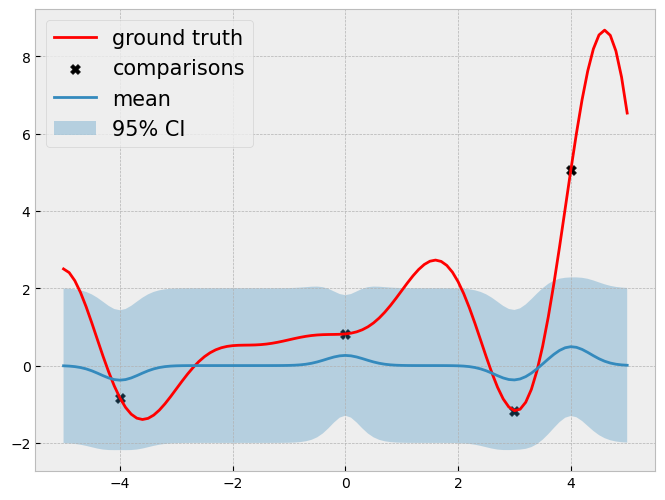

In [10]:
plt.plot(xs, ys, label="ground truth", c="r")
plt.scatter(train_x, objective(train_x), c="k", marker="X", s=50, label="comparisons")

plt.plot(xs, pred_mean, label="mean")
plt.fill_between(
    xs.flatten(),
    pred_lower,
    pred_upper,
    alpha=0.3,
    label="95% CI",
)

plt.legend(fontsize=15);